# generate videos of spiral tips with streams predictive of extinction dynamics
Tim Tyree<br>
3.22.2022

In [1]:
from lib.my_initialization import *
from lib.model.minimal_model_cuda import *
from lib import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [3]:
# 993MiB /  7982MiB
# 7982/993=8.03...>8
npartitions_gpu=1
npartitions=os.cpu_count()-1
assert npartitions>0

In [4]:
import pycuda.autoinit

In [13]:
import shutil
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [41]:
# !pip install mayavi
1

1

In [5]:
# import vtk

In [6]:
# import mayavi

In [5]:
#input: gpu output in cpu memory
#ouput:  dict_out,img,dimg_dt
def measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold,**kwargs):
    """
    kwargs may not be conected to anything
    returns dict_out,img,dimg_dt
    Example Usage:
dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
    """
    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    # #DONE: compute spiral tip locations and verify that they look reasonable
    #compute flow map
    zero_txt=np.zeros_like(txt)
    dtxt_dt=zero_txt#.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t=9999.,img=img,dimgdt=dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)

    #compress data to be plotted
    # dimg_dt=dtxt_dt[...,0]
    # img=txt[...,0]
    dimg_dt=dtxt_dt[...,0].astype(np.float32) #looks the same as float64
    img=txt[...,0].astype(np.float32)
    # dVdt=dtxt_dt[...,0].astype(np.float16) #this bugs up the streamplots
    # img=txt[...,0].astype(np.float16)
    return dict_out,img,dimg_dt

In [6]:
#DONE: dev viewer routine_to_png
#input: dict_out,img,dimg_dt,save_dir
#output: save_dir
def routine_to_png_streaming_tips(task):
    dict_out,img,dimg_dt,save_dir=task
    #define constant parameters
    # fontsize=22
    # xy=(0.75, 0.9)
    inch=6
    fontsize=30
    xy=(0.67, 0.9)
    #define constant coordinate mesh for stream generation
    width=200.#pixel
    height=200.#pixel
    DX=0.025#cm/pixel
    #generate plot
    #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
    fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
    ax=fig.add_subplot()
    #plot the mesh
    X_=np.arange(width)
    Y_=np.arange(height)
    X,Y = np.meshgrid(X_, Y_)
    ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='gouraud')
    #ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='auto')
    #     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone')
    #     ax.pcolormesh(X, Y, img, shading='auto',cmap='bone')

    #compute vector field #note notes are for LR model
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
#     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
#     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
    ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
    vx=ddVdtdx #still looks meh?
    vy=ddVdtdy
    use_streamplot=True
#     use_streamplot=False
#     if use_streamplot:
#         #compute the streamplot
#         strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
#                              density=0.5)#density=2)#way too much 
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        if use_streamplot:
            start_points = list(zip(x_values,y_values))
            strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                              color="crimson", #"orange", 
                              linewidth=2,
        #                       integration_direction='forward')
        #                       integration_direction='backward')
                              integration_direction='both')
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

        if use_streamplot:
            #record the stream for later analysis
            stream_array=strmS.lines.properties()['segments']
            dict_out['stream_array']=stream_array
    
    #complicated formatting
    #add text of label
#     label=f"Vth={V_threshold}"
    if use_streamplot:
        #record the stream for later analysis
        label=r"$-\nabla \partial_tV$"#+'\n'
        ax.annotate(label, xy=xy, 
                xycoords='axes fraction',
    #             xycoords='data',
    #             xycoords='polar',
                fontsize=fontsize,alpha=0.8)
    #(alternative method with small font...)add text box with label
    # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
    # ax.add_artist(anchored_text)
    # anchored_text.set_alpha(0.1)
    # annotating=False
    # if annotating:
    #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
    #     message_string=f"  num. = {n_tips}"
    #     ax.text(.0,.95,time_step_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    #     ax.text(.0,.9,message_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    ax.axis("off")
    plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return save_dir

# #DONE: dev viewer routine_to_png
# #input: dict_out,img,dimg_dt,save_dir
# #output: save_dir
# def routine_to_png_streaming_tips(task):
#     dict_out,img,dimg_dt,save_dir=task
#     #define constant parameters
#     # fontsize=22
#     # xy=(0.75, 0.9)
#     inch=6
#     fontsize=30
#     xy=(0.67, 0.9)
#     #define constant coordinate mesh for stream generation
#     width=200.#pixel
#     height=200.#pixel
#     DX=0.025#cm/pixel
#     #generate plot
#     #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
#     fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
#     ax=fig.add_subplot()
#     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='gouraud')
#     #ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='auto')
#     #     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone')
#     #     ax.pcolormesh(X, Y, img, shading='auto',cmap='bone')

#     #compute the streamplot
#     X_=np.arange(width)
#     Y_=np.arange(height)
#     #X,Y = np.meshgrid(X_, Y_)
#     #compute vector field
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     vx=-ddVdtdx #looks good
#     vy=-ddVdtdy
#     # vx=ddVdtdx #looks meh
#     # vy=ddVdtdy
#     strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
#                          density=0.5)#density=2)#way too much 
#     x_values=np.array(dict_out['x'])
#     y_values=np.array(dict_out['y'])
#     if x_values.shape[0]>0:
#         boo=(x_values<width-1.)&(y_values<height-1.)
#         x_values=x_values[boo]
#         y_values=y_values[boo]
#         start_points = list(zip(x_values,y_values))
#         strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
#                               color="crimson", #"orange", 
#                               linewidth=2,
#         #                       integration_direction='forward')
#         #                       integration_direction='backward')
#                               integration_direction='both')
#         ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

#     #complicated formatting
#     #add text of label
# #     label=f"Vth={V_threshold}"
#     label=r"$-\nabla \partial_tV$"#+'\n'
#     ax.annotate(label, xy=xy, 
#                 xycoords='axes fraction',
#     #             xycoords='data',
#     #             xycoords='polar',
#                 fontsize=fontsize,alpha=0.8)
#     #add text box with label
#     # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
#     # ax.add_artist(anchored_text)
#     # anchored_text.set_alpha(0.1)
#     # annotating=False
#     # if annotating:
#     #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
#     #     message_string=f"  num. = {n_tips}"
#     #     ax.text(.0,.95,time_step_string,
#     #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
#     #             transform=ax.transAxes)
#     #     ax.text(.0,.9,message_string,
#     #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
#     #             transform=ax.transAxes)
#     ax.axis("off")
#     plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#     plt.close();
#     return save_dir

# test my gpu accelerated one_step method for the Fenton-Karma model

In [7]:
#load parameters for parameter set 8 for the Fenton-Karma Model
kwargs = read_parameters_from_json('lib/model/param_set_8.json')
print(F"default parameters:")
print_dict(kwargs)

default parameters:
diffCoef=0.0005
C_m=1.0
tau_pv=13.03
tau_v2=19.6
tau_v1=1250
tau_pw=800
tau_mw=40
tau_d=0.45
tau_0=12.5
tau_r=33.25
tau_si=29
K=10
V_sic=0.85
V_c=0.13
V_v=0.04


200000 time steps took 14319 ms.


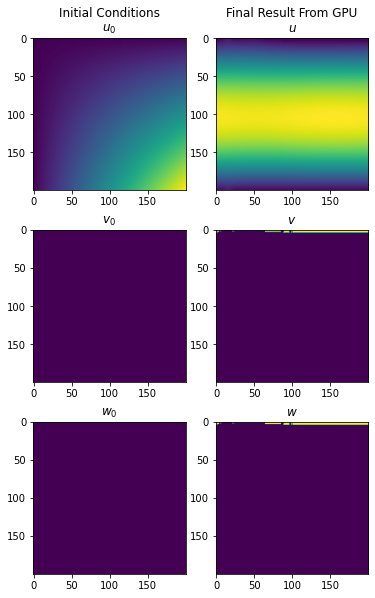

In [8]:
# from lib.model.minimal_model_cuda import *
#the following might be needed for the kernel_autotuner.
# drv.init()

#define how resources are used
width  = 200
height = 200
block_size_x=10
block_size_y=10
threads = (block_size_x,block_size_y,1)
grid = (int(width/block_size_x), int(height/block_size_y), 1)
block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

#set spatial discretization
DX=0.025 #cm
# DY=0.025
DT=0.025 #ms

#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#load parameters for parameter set 8 for the Fenton-Karma Model
# kwargs = read_parameters_from_json('lib/model/param_set_8.json')
kwargs['width']=width
kwargs['height']=height
kwargs['DX']=DX
# kwargs['DT']=DT
# kwargs['DY']=DY

#define the initial conditions
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

u_initial = Vin.astype(np.float64)
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()

In [29]:
print_dict(kwargs)

diffCoef=0.0005
C_m=1.0
tau_pv=13.03
tau_v2=19.6
tau_v1=1250
tau_pw=800
tau_mw=40
tau_d=0.45
tau_0=12.5
tau_r=33.25
tau_si=29
K=10
V_sic=0.85
V_c=0.13
V_v=0.04
width=200
height=200
DX=0.025


## print the kernel_string for the one_step method for the Fenton-Karma model

In [32]:
print(kernel_string)


// primary model parameters
#define width  200
#define height 200
#define h      0.025
#define C_m    1.0
#define tau_pv 13.03
#define tau_v1 1250.0
#define tau_v2 19.6
#define tau_pw 800.0
#define tau_mw 40.0
#define tau_d  0.45
#define tau_0  12.5
#define tau_r  33.25
#define tau_si 29.0
#define K      10.0
#define V_sic  0.85
#define V_c    0.13
#define V_v    0.04

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef 0.80000000

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {
    if (q >= wid) {
        q = 0;
    }
    if (q < 0) {
        q = wid-1;
    }
    return q;
}

// heaviside step function
__device__ double step(double thresh, double x)
{
    return x >= thresh;
}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
 

# dev

In [9]:
from lib.viewer.viewer_cluster import *

In [36]:
# #DONE: load from a whole other folder of initial condition from the Fenton-Karma model
# ic_fn=f"{nb_dir}/Data/initial-conditions-suite-1/ic-in/ic_200x200.108.13.npz"
# txt_fk=load_buffer(ic_fn)
# txt_fk.shape

In [37]:
# load an initial conditions and integrate forward 100ms
printing=True
tf=100.
iterations = int(np.around(tf/DT))
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-in/'
ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'

ic_fn_lst=["ic200x200.0.0.npz",   "ic200x200.0.59.npz",  "ic200x200.1.34.npz",  "ic200x200.2.0.npz",   "ic200x200.2.59.npz",  "ic200x200.3.34.npz",
"ic200x200.0.10.npz",  "ic200x200.0.5.npz",   "ic200x200.1.35.npz",  "ic200x200.2.10.npz",  "ic200x200.2.5.npz",   "ic200x200.3.35.npz"]

for ic_fn in ic_fn_lst:
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")

    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)
    # plt.imshow(txt[...,0],cmap='gray')
    # plt.axis('off')
    # plt.show()

    t=0

    # iterations = 67
    if printing:
        print(f"forward integrating to tf={tf:.3f} ms (iterations={iterations})...")

    #define the initial conditions
    u_initial=txt[...,0].copy()
    v_initial=txt[...,1].copy()
    w_initial=txt[...,2].copy()

    #don't allocate memory many times for the same task!
    #allocate GPU memory for voltage scalar field
    u_old = drv.mem_alloc(u_initial.nbytes)
    u_new = drv.mem_alloc(u_initial.nbytes)
    #allocate GPU memory for v and w auxiliary fields
    v_old = drv.mem_alloc(v_initial.nbytes)
    v_new = drv.mem_alloc(v_initial.nbytes)
    w_old = drv.mem_alloc(w_initial.nbytes)
    w_new = drv.mem_alloc(w_initial.nbytes)

    # explicit time integration up to 5 seconds in steps of size 0.025 ms
    kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

    #setup thread block dimensions and compile the kernel
    mod = SourceModule(block_size_string+kernel_string)
    time_step_kernel = mod.get_function("time_step_kernel")

    # #create events for measuring performance
    # start_timer = drv.Event()
    # end_timer = drv.Event()

    #move the data to the GPU
    drv.memcpy_htod(u_old, u_initial)
    drv.memcpy_htod(u_new, u_initial)
    drv.memcpy_htod(v_old, v_initial)
    drv.memcpy_htod(v_new, v_initial)
    drv.memcpy_htod(w_old, w_initial)
    drv.memcpy_htod(w_new, w_initial)

    #call the GPU kernel 2*iterations times and measure performance
    context.synchronize()
    # start_timer.record()
    for step in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
        #update progressbar
        if printing:
            printProgressBar(step + 1, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
    # end_timer.record()
    context.synchronize()
    # runtime = end_timer.time_since(start_timer)
    print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python for plotting
    gpu_result_u = np.zeros_like(u_initial)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_initial)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_initial)
    drv.memcpy_dtoh(gpu_result_w, w_old)

    #record final time as new time
    t=tf

    # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
    # ax1.imshow(u_initial)
    # ax1.set_title("Initial Conditions\n$u_0$")
    # ax2.imshow(gpu_result_u)
    # ax2.set_title("Final Result From GPU\n$u$")
    # ax3.imshow(v_initial)
    # ax3.set_title("$v_0$")
    # ax4.imshow(gpu_result_v)
    # ax4.set_title("$v$")
    # ax5.imshow(w_initial)
    # ax5.set_title("$w_0$")
    # ax6.imshow(gpu_result_w)
    # ax6.set_title("$w$")
    # plt.show()

    #init methods for instantaneous spiral tip detection
    diffCoef=kwargs['diffCoef']
    dsdpixel=kwargs['DX']
    get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
    # one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
    # V_threshold=-60
    V_threshold=0.4
    compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    #cache txt for initialization
    txt_init=txt.copy()

    zero_txt=np.zeros_like(txt)

    # #compute flow map
    # dtxt_dt=zero_txt.copy()
    # get_time_step_fk(txt, dtxt_dt)
    # plt.imshow(dtxt_dt[...,0],cmap='bone',vmin=0,vmax=0.5)
    # plt.axis('off')
    # plt.show()

    #compute spiral tip locations and verify that they look reasonable
    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    print_dict(dict_out)
    if dict_out['n']>0:
        #generation of results
        # printing=True
        save_every=67
        save_every=22 #~30X slowdown
        fps=60 #i checked the ffmpeg routine
        # video_duration=30 #seconds
        video_duration=15 #seconds
        pause_after_termination_duration=1. #second
        accumulated_time_after_termination=0.
        V_threshold=0.4 #appears best
        # V_threshold=0.2
        # V_threshold=0.8
        # V_threshold=0.95
        #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time
        
        #define the initial conditions
        t=tf #ms
        txt=txt_init.copy()
        u_initial=txt[...,0].copy()
        v_initial=txt[...,1].copy()
        w_initial=txt[...,2].copy()

        #don't allocate memory many times for the same task!
        #allocate GPU memory for voltage scalar field
        u_old = drv.mem_alloc(u_initial.nbytes)
        u_new = drv.mem_alloc(u_initial.nbytes)
        #allocate GPU memory for v and w auxiliary fields
        v_old = drv.mem_alloc(v_initial.nbytes)
        v_new = drv.mem_alloc(v_initial.nbytes)
        w_old = drv.mem_alloc(w_initial.nbytes)
        w_new = drv.mem_alloc(w_initial.nbytes)

        # explicit time integration up to 5 seconds in steps of size 0.025 ms
        kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

        #setup thread block dimensions and compile the kernel
        mod = SourceModule(block_size_string+kernel_string)
        time_step_kernel = mod.get_function("time_step_kernel")

        # #create events for measuring gpu performance
        # start_timer = drv.Event()
        # end_timer = drv.Event()

        #move the data to the GPU
        drv.memcpy_htod(u_old, u_initial)
        drv.memcpy_htod(u_new, u_initial)
        drv.memcpy_htod(v_old, v_initial)
        drv.memcpy_htod(v_new, v_initial)
        drv.memcpy_htod(w_old, w_initial)
        drv.memcpy_htod(w_new, w_initial)

        #time evolve txt on gpu saving to cpu once every 67 time steps
        iterations=save_every
        number_frames=np.around(video_duration*fps)
        nsteps=number_frames
        t_final=tf+DT*iterations*nsteps
        if printing:
            print(f"system initialized at time: {t} ms")
            print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
            print(f"forward integrating to tf={t_final/1e3} seconds...")
        dict_out_lst=[]
        img_lst=[]
        dimg_dt_lst=[]
        start = time.time()
        for step in range(nsteps):
            #call the GPU kernel 2*iterations times and measure performance
            context.synchronize()
            #start_timer.record()
            for i in range(iterations):
                time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
                time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
            #end_timer.record()
            context.synchronize()
            #runtime = end_timer.time_since(start_timer)

            #copy the result from the GPU to Python for plotting
            gpu_result_u = np.zeros_like(u_initial)
            drv.memcpy_dtoh(gpu_result_u, u_old)
            gpu_result_v = np.zeros_like(v_initial)
            drv.memcpy_dtoh(gpu_result_v, v_old)
            gpu_result_w = np.zeros_like(w_initial)
            drv.memcpy_dtoh(gpu_result_w, w_old)

            #measure
            dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
            #update time
            t=(tf+DT*step*iterations)*0.001 #seconds
            dict_out['t']=t
            #record
            dict_out_lst.append(dict_out)
            img_lst.append(img)
            dimg_dt_lst.append(dimg_dt)
            #update progressbar
            if printing:
                n=dict_out['n']
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds, num. tips:{n})', length = 50)

            if dict_out['n']==0:
                #the number of tips is zero
                accumulated_time_after_termination+=DT*iterations
                if accumulated_time_after_termination>pause_after_termination_duration:
                    # break the inner loop
                    break
            else:
                # continue if the inner loop wasn't broken
                continue
            # inner loop was broken, break the outer
            break

        runtime = time.time() - start
        if printing:
            print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
        # beep(1)

        #generate movie of data currently in virtual memory
        dump_cache=True
        save_folder = os.path.join(nb_dir,f'Figures/mov')
        #dump save_folder if it already exists
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        assert (os.path.exists(save_folder))
        if dump_cache:
            shutil.rmtree(save_folder)
            print(f"dumped cache at {save_folder}")
            os.mkdir(save_folder)

        task_lst=[]
        for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
            save_fn=f"img{frameno:07d}.png"
            save_dir=os.path.join(save_folder,save_fn)
            task=dict_out,img,dimg_dt,save_dir
            task_lst.append(task)
        task_lst.pop(-1)
        if printing:
            print(f"added {len(task_lst)} tasks to task_lst")

        testing=False
        if testing:
            task_index=-100
            task = task_lst[task_index]
            routine_to_png_streaming_tips(task)
            if printing:
                print(task[-1])

        if printing:
            print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
            print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
            print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
            #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time

        # # DONE: make the stream plot with this particle current, as before, but only where there are particles
        # #     - option 0: ignore the following details and just do what I already did.
        # #     - option 1: add streams with periodic boundary conditions (only if easy fix found on stackoverflow!)
        # #     - option 2: add streams on the interior only
        # #DONE: save ^that to .png with zero borders, as before
        # #DONE: wrap ^that into a viewer routine_to_png(task)
        # #TODO: eval_viewer_cluster
        #this took 1 hour for 1 trial
        start=time.time()
        if printing:
            print(f"generating {len(task_lst)} .png files over {npartitions} cores...")
        retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
        if printing:
            print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
        #beep(2)
        #NOTE: the following was much slower
        # #concatenate the folder of png files to a video
        # os.chdir(f"{nb_dir}/../vid/src")
        # !./concat_folder_png.sh
        # if printing:
        #     print(f"V_threshold={V_threshold}")
        # beep(3)
        #concatenate the folder of png files to a video
        os.chdir(f"{nb_dir}/../vid/src")
        os.system("./concat_folder_png.sh");
        #copy output movie to a file uniquely named for this recording session
        # fn=ic_fn
        fn=os.path.basename(ic_dir)
        use_streamplot=True
#         use_streamplot=False
        if use_streamplot:
            save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
            os.chdir(f"{nb_dir}/../vid/mov")
            folder=f'streaming_tips_fenton_karma_diffCoef_{diffCoef}'
        else:
            save_mov_fn=fn.replace('.npz','.mov')
            os.chdir(f"{nb_dir}/../vid/mov")
            folder=f'fenton_karma_diffCoef_{diffCoef}'
        if not os.path.exists(folder):
            os.mkdir(folder)
        os.system(f"cp out.mov {os.path.join(folder,save_mov_fn)}")
        if printing:
            print(f"{os.path.abspath(save_mov_fn)}")
        #save dict_out_lst to .pkl in new folder in Data/
        save_pkl_folder=os.path.join(ic_folder,'..',folder)
        if not os.path.exists(save_pkl_folder):
            os.mkdir(save_pkl_folder)
        save_pkl_fn=fn.replace('.npz','.pkl')
        save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
        save_to_pkl(save_pkl_dir,dict_out_lst)
        print(f"save_pkl_dir='{save_pkl_dir}'")

ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.0.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
8000 time steps took 14302 ms.███████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=4
x=[47.70461999486014, 57.502692892985685, 114.9745263162495, 174.08240644565404]
y=[130.32990113166036, 160.0729817770988, 14.145258157437949, 119.2985635346965]
grad_ux=[0.36029275957792317, 1.376542188512733, 0.863307370513411, 0.7187016415982683]
grad_uy=[1.2303286764719392, 0.8645659396024787, 2.070882090091564, 1.4128924517481047]
grad_vx=[1.7888276476205653, -0.9891870829127515, 1.0702180362237466, 5.394408377345041]
grad_vy=[0.7097386572508284, 1.7133260245974722, 0.42654091158790974, -5.413771303847788]
system initialized at time: 100.0 ms
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complet

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=26
x=[1.7853958123190476, 15.354526501607461, 29.907575357034943, 42.15252001480286, 51.21932415722027, 56.48344009891648, 58.495819695375125, 59.030952896421496, 68.46858707036166, 70.697770119316, 107.32224409978201, 112.16100192373587, 124.47109225560665, 145.75390208679613, 150.70970227910252, 155.89972250385213, 163.60593915964265, 172.72031933250267, 187.14724238512213, 193.50727271195237, 196.86418978829658, 197.6580493698439, 199.3923797032955, 199.3581332484514, 199.24981429406137, 199.2501040124706]
y=[199.4086350483645, 79.2100699546597, 8.695605563909481, 94.54986268085764, 0.15725237635331246, 97.03917183934398, 199.73790764319486, 96.72197587597623, 197.53018300181904, 49.12191044487304, 118.59605554642528, 0.4017192562359371, 199.35023031332733, 51.47697907097981, 99.50997689467302, 196.91159690015883, 76.40615456144577, 197.09621023437944, 199.55706746404132, 48.978763900938645, 153.46264714292957, 87.79535794444702, 11.827686687794706, 47.0317199107733, 89.97

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=14
x=[1.897812601673663, 13.651749636752166, 15.20725904778485, 36.96706781395055, 42.91786076968986, 55.896730238074184, 72.52660130214612, 91.11514212536444, 150.71278033655494, 165.06396372815024, 166.09950197490465, 170.77979528624343, 199.50756650372162, 199.1888846457104]
y=[91.25109352275156, 24.967091014692876, 172.56450868850726, 53.95404579832194, 199.38598120911394, 199.84076740752826, 122.24554413398744, 199.48895531702462, 0.5549355289162442, 198.00440314928397, 199.1261623215318, 191.39470979280455, 46.92271403852445, 81.49694413427882]
grad_ux=[-0.1895460056884114, -0.8237594885001378, 1.5479518338838378, 0.03745126829080555, -0.08630857672987054, 0.028124673060874045, -2.056825959642542, 0.20970534595601634, 0.6934857447896976, 28.813097473753306, -0.9552877733922113, 0.6189918796511812, 1.2642577086263243, 1.0697781701419389]
grad_uy=[1.0260665363844026, 1.960138155417904, 0.9524626175862224, 1.6600949559517035, 1.2289013285798143, 1.2723450310291937, 2.82026

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=22
x=[24.378957377490902, 28.198011647311922, 62.26523785177767, 63.5207687608703, 65.93865324645488, 68.16754304447178, 83.09059182434194, 100.82067392269602, 107.56603443930368, 115.25544352189584, 123.07211651081757, 123.7000693341627, 123.83895328418043, 127.86282217131588, 155.0008347003726, 160.29826097217884, 166.2796732945809, 177.3161809179562, 186.04674415114286, 199.59310370384964, 199.65137157089026, 199.46640829518395]
y=[9.956666699705695, 9.676901010237566, 42.74817184759611, 196.9796654302014, 199.45650527397376, 1.6884666157820254, 199.5754851189768, 195.9644142920654, 66.00734794717228, 187.10794667814682, 188.99200446173535, 198.97847642793968, 199.040904362754, 199.49054674144475, 198.08234613802523, 1.4917522547335869, 51.305614367268284, 199.31556264050866, 128.98396772549398, 36.97028454967108, 54.51030595870572, 144.51968476045005]
grad_ux=[0.1600444343134771, 0.6068614730073457, -2.420804629379804, 1.8205421622533546, -0.8646011007740277, 1.0358069625

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=14
x=[0.13341217767279173, 21.81109441273909, 38.402513707317404, 48.342555703842905, 49.79578373720582, 71.29569010201143, 79.00538488525727, 95.0239379250006, 118.93956693644917, 128.47828602278517, 162.5029181631142, 187.78505965116747, 192.36141335546773, 192.5969043183032]
y=[71.40600790642597, 196.00970757076513, 197.034931860769, 27.57013086510858, 179.52358846202006, 108.63593710014045, 199.3877757654963, 165.14847196098899, 199.49084336349583, 140.59600170180448, 196.98107958405572, 116.9065622728494, 0.4073012758039838, 23.41376028956905]
grad_ux=[2.2609531024473206, 2.563929441871891, 0.865199830247289, 8.803860924417847, 0.14784987638757047, 2.6243987538243396, -0.01645434778991888, 2.2514080472134217, 0.1890745183389116, -5.019334011544201, 0.362135335686911, 1.596696869541521, 1.0, 1.3591007487407654]
grad_uy=[1.0, 0.8259392683807791, 1.0259527428303468, -12.704632668544878, 1.2373687972805898, -0.06263067322768111, 1.4078063801235114, 0.27917115521217944, 1.483

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=24
x=[2.6237804161377576, 14.33690852818941, 19.284158464890485, 22.285841130834154, 24.90804602138518, 28.769773332098787, 30.269517975271302, 44.9345251404132, 44.8980452875645, 74.87131662747034, 81.8950453988899, 95.58855716031336, 150.80298552626954, 154.99498359143882, 155.9541012327345, 156.0268717659659, 170.4280936564989, 178.72151599303714, 178.58556015670942, 180.3444801319004, 196.75017140365875, 196.84627232344388, 199.68233443873947, 199.4839145355482]
y=[89.96993420366317, 37.16300446853972, 74.32907950363683, 66.63880275560318, 88.54073122255015, 199.498284573378, 0.6035544190779257, 0.12057545544282998, 199.96939987832832, 185.60264436119135, 1.8432923218574222, 27.854833368757767, 12.718683309263495, 199.14054204096814, 121.65854459814953, 198.30076487746067, 105.34454663101626, 56.46691873652936, 199.2123727947409, 197.23215960965254, 14.708833064436302, 102.81801463400103, 64.84589773746609, 93.9739570514276]
grad_ux=[-0.2817633375394027, 0.839207650186671

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=20
x=[0.31435795992488974, 1.388166314554344, 20.24633316207156, 28.549647037108702, 32.805142296780076, 32.31030967430667, 33.46677628023359, 62.67697364740409, 66.53931287972071, 78.08832631246378, 106.06608802953802, 121.13682321419965, 150.10505634638145, 151.8508678639248, 157.66302469665362, 173.89929965376183, 178.9187266688843, 197.31482883471926, 199.21671219611173, 199.5334348718614]
y=[11.55271140610903, 13.288044309903418, 199.74784351282253, 1.8192430300726394, 1.8548701654872164, 41.17794102205476, 135.9955294926648, 105.65226191335319, 61.78402070285237, 199.46591463918298, 2.2420875506815694, 117.37767844140296, 196.73643495955494, 27.68590554389226, 110.11524635927408, 199.78165968448513, 0.8562621633659129, 134.10819461523707, 138.77989721854934, 159.8433322693298]
grad_ux=[-2.2006609448693766, -1.0869330882969659, -0.12015015749110353, 1.1969158976215413, 0.9787211086321607, -0.48737510031370734, 4.47919454494737, 1.3425707751569242, 6.152825667885784, 0.25

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=18
x=[11.581398531568857, 23.652004484588673, 36.69061512600669, 40.75608559802999, 52.19067803206615, 78.88202410126418, 87.3952939819097, 99.35905349419527, 129.2277566137289, 168.04212191231298, 171.24766358174935, 183.5007254994772, 191.91589433608448, 199.25190388361665, 199.76011484707706, 199.33890989648148, 199.25119999626216, 199.48575147387078]
y=[199.63898257305763, 12.278128053012741, 196.88641122499627, 14.550054633498593, 62.42082768395728, 1.858405967518445, 35.22915308589215, 199.5019562976208, 15.112472588142179, 116.34892144339089, 9.898334344291538, 108.53861209374993, 2.02733067877198, 0.07807964389163438, 5.431602516392476, 58.73207005968118, 73.97455630162997, 116.30196418238768]
grad_ux=[0.15827939227004068, 1.625236605907552, 3.6527432031814024, 1.144942152880501, -9.019410984245592, 0.986398058315045, 0.9879272545154723, 0.0654601532678306, -1.3955646043933911, 0.7846134055146978, 0.9168019202243388, 14.514996610580667, 1.0086463392702487, 1.0, 1.0276

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=10
x=[38.652220007317176, 40.194483744001644, 92.92983717016395, 113.96562159001928, 115.03941272492078, 143.55455523363796, 153.5461693682022, 177.60715195929035, 189.9892835226842, 196.5881184188297]
y=[2.071373638879706, 69.98671052056132, 46.0191841821356, 199.48008732333423, 18.29845797303479, 198.60913503291337, 197.26429790764644, 197.3583296938004, 168.4810511295345, 118.04645176221008]
grad_ux=[1.0691323624032223, 2.285674642667583, 0.8557164525048637, 0.22017835776460057, 0.4474639539926749, 0.2839072233848362, 0.2519900547357762, -0.9628748307750129, -2.9554908483393096, 0.9993797948491068]
grad_uy=[-0.3352859397081521, 0.24905423328763956, 1.2915744433576488, 1.4414211830777746, 4.521003572598476, 1.5153223438797863, 1.5799072909840888, 2.7622859725013504, 5.452324859215226, 1.0010335069571552]
grad_vx=[1.3348413651982336, 0.05458651082336988, 0.4060212377552191, 0.00864665217081566, 1.1866905558644827, -1.024935215136418, -0.06268089830962999, 0.21646710560673896

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=18
x=[1.861928951677767, 1.3179545094272196, 3.976594280665135, 10.181621869753252, 17.19336370728353, 26.445806517113617, 42.81649513247456, 74.43920229612289, 104.48495489601606, 104.54623913860142, 107.15667042549701, 129.7878445651307, 169.0417723534767, 172.23331264899468, 196.05645727388907, 199.6440131752134, 199.6869250162649, 199.41410415477787]
y=[21.760025602072094, 199.63736817725106, 122.68200972267577, 87.88439932839395, 196.79402151709706, 179.18690506737815, 197.90804861978813, 2.141781370321313, 198.97459054649408, 199.00350652983434, 61.02720523727922, 199.72931604397874, 120.13214324300361, 199.6613030306287, 39.32911499785613, 71.35477135256578, 127.88916640068004, 153.60858190047387]
grad_ux=[-3.244896661472896, -0.2554881884745382, 1.1011013071869384, 1.323532098251707, -4.131938107354816, 0.2154666877274026, 2.0287850238348475, 1.0488480101668776, -1.0289283249870562, -0.6272713323535606, 0.7897893243389029, 0.11801810565155478, 3.0899322070625366, -0.5

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=10
x=[12.869331850453554, 16.010827394304474, 52.24098789385241, 56.616006224173965, 77.46817070702215, 100.37449452945059, 179.0859911425287, 197.02741964233397, 198.69065677265797, 199.51584326331854]
y=[177.9097213128715, 197.0913726624376, 156.9595774827233, 57.757609815849875, 2.134271275334072, 2.1784160897414666, 196.99359476312637, 169.05735037791976, 199.44573647478921, 0.2901279422955364]
grad_ux=[1.7510767785459895, 0.6226918615915527, -4.940599935892841, 0.23321449390085816, 1.008569375971718, 1.0345849415362216, 2.2574036049630233, -4.147995513612432, -2.086108003787083, 1.0]
grad_uy=[0.9450434529494854, 1.0306290923075565, 2.9731281418405464, 1.742391828311031, 0.6676921931308469, -0.15860064119583392, -0.1484754988744714, 7.0088747600908725, 4.069186176933312, -0.467630891706615]
grad_vx=[-0.502789287013341, -0.12017122054580526, 0.23691855998106096, 2.147809989591741, 1.1331138962431648, 0.916398668244119, 0.17169025958117756, 1.6214972460446455, 0.00242465769

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


t=100.0
n=12
x=[1.9071813861603406, 1.4736350079863945, 23.424781865137504, 61.24106173621603, 118.46786494254862, 124.08283211068085, 135.56069210294498, 145.00714714451232, 179.87077214145185, 196.750585380549, 199.56208197230166, 199.8837761181397]
y=[34.055078487357285, 105.31397990642327, 122.20175564556689, 144.32281437584058, 2.2989818807198943, 199.660053401028, 199.5336588318817, 191.46355810682758, 7.846602616257809, 129.2601521171777, 9.572666232645773, 33.597589339528426]
grad_ux=[0.08918253143216479, -1.1817455362001084, 0.8586895097860576, 1.0831819831924152, 1.0396559770648692, 0.328969586801974, 0.4543400324228725, 0.8053104260664594, 1.087102791973269, -0.3050259520767087, 1.0601416158133605, 1.3810983801142347]
grad_uy=[1.026683677783638, 1.0249614818683597, 1.0265194067798744, 0.9649078027193627, -1.3413310804188225, 1.420555461797372, 1.3688372893545178, 1.1474392773713717, -0.9616037588151541, 2.9800162900983156, -0.2006851185263067, -1.3018397740693413]
grad_vx=[2

./concat_folder_png.sh: line 9: ffmpeg: command not found
./concat_folder_png.sh: line 38: ffmpeg: command not found
./concat_folder_png.sh: line 56: ffmpeg: command not found
./concat_folder_png.sh: line 57: ffmpeg: command not found
./concat_folder_png.sh: line 63: ffmpeg: command not found
./concat_folder_png.sh: line 67: ffmpeg: command not found


In [38]:
task_lst

[({'t': 0.1,
   'n': 10,
   'x': [0.987255104787158,
    23.17148022552694,
    60.884784660454336,
    118.65730767603895,
    122.37636392838486,
    135.41683565794108,
    144.59572614342892,
    180.00907489206034,
    196.5910945502965,
    199.65524223877543],
   'y': [104.43996513029185,
    122.43190099361918,
    144.7085204912515,
    2.4736571574287565,
    0.14498885915485216,
    199.58806581747024,
    191.77075038242882,
    8.012973601784285,
    129.25046691661404,
    9.880291851734862],
   'grad_ux': [-3.9032571790321144,
    0.9848821772353609,
    1.0416231952664115,
    1.023706761709066,
    1.0,
    0.6987025229962289,
    0.8180078567959799,
    1.0832891044439699,
    0.56803790952161,
    1.0772021473477207],
   'grad_uy': [1.041013611621114,
    1.0028361259465188,
    0.9826015556769161,
    -0.40427305549350584,
    2.576342969652011,
    1.2035487588456546,
    1.1367568073709706,
    -0.6715283916549782,
    1.6540154710167645,
    -0.5418462134398998],

In [ ]:
# # #time evolve txt on gpu saving to cpu once every 67 time steps
# # iterations=save_every
# # number_frames=np.around(video_duration*fps)
# fps
# step

In [39]:
print(f"save_pkl_dir='{save_pkl_dir}'")

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../streaming_tips_fenton_karma_diffCoef_0.0005/ic200x200.3.35.pkl'


In [40]:
# from lib.utils.pickleio import *
os.path.join('f','d','a')

'f/d/a'

In [ ]:
# # - DONE: add $-\nabla\partial_t V_m$ as an inset text box with a white background, plt.axis('off')
# # - DONE: make a function that saves a matplotlib plot to .png as a video frame, as before
# # - DONE: determine a reasonable frame rate
# # - DONE: forloop over this, generating a folder of .png frames
# # - DONE: concatenate folder of  .png frames using ffmpeg, as before
# # - DONE: if the movie looks good and is reasonably small in memory, consider sharing it... or share it during our recurring meeting tomorrow at 2pm with WJ and PM

# # TODO: repeat for (gpu_accelerated?) one_step method from the Luo-Rudy model
# then,
# TODO: overnight, let a folder of comparable small videos be generated for either/both of the full models
# HINT: try both 



# TODO: dev new Fig. 1A with spiral tips about to annihilate from FK with arrows indicating future trajectories

In [ ]:
# #init methods for instantaneous spiral tip detection
# diffCoef=kwargs['diffCoef']
# dsdpixel=kwargs['DX']
# get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
# # one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
# # V_threshold=-60
# V_threshold=0.4
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

In [10]:
#options
# ic_fn_lst=["ic200x200.0.0.npz",   "ic200x200.0.59.npz",  "ic200x200.1.34.npz",  "ic200x200.2.0.npz",   "ic200x200.2.59.npz",  "ic200x200.3.34.npz",
# "ic200x200.0.10.npz",  "ic200x200.0.5.npz",   "ic200x200.1.35.npz",  "ic200x200.2.10.npz",  "ic200x200.2.5.npz",   "ic200x200.3.35.npz"]

# pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../streaming_tips_fenton_karma_diffCoef_0.0005/ic200x200.2.10.pkl'
pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../streaming_tips_fenton_karma_diffCoef_0.0005/ic200x200.3.35.pkl'
dict_out_lst=load_from_pickle(pkl_dir)

In [11]:
dn_lst=[]
df_tips_lst=[]
for dicto in dict_out_lst:
    dn_lst.append(dict(
        t=dicto['t'],
        n=dicto['n']))
    df_tips_lst.append(pd.DataFrame(dicto))
    
dn=pd.DataFrame(dn_lst)
df=pd.concat(df_tips_lst)
# dn.head()
df.head()

,t,n,x,y,grad_ux,grad_uy,grad_vx,grad_vy
0,0.1,10,0.987255,104.439965,-3.903257,1.041014,-1.806573,1.026867
1,0.1,10,23.171480,122.431901,0.984882,1.002836,1.414147,0.922365
2,0.1,10,60.884785,144.708520,1.041623,0.982602,23.533393,-8.487381
3,0.1,10,118.657308,2.473657,1.023707,-0.404273,-3.581892,220.926667
4,0.1,10,122.376364,0.144989,1.000000,2.576343,1.028601,-25.839555


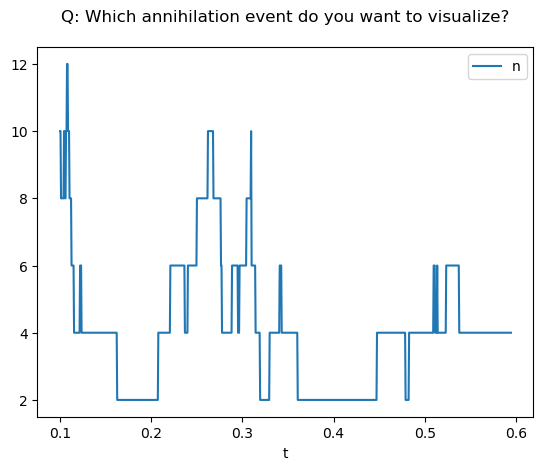

In [14]:
dn.plot(x='t',y='n')
plt.title("Q: Which annihilation event do you want to visualize?\n")
plt.show()

In [15]:
#identify time points where n --> n-2 after tstart=0.13 seconds
# DONE: select first time points where n --> nfinal=n-2 after tstart=0.13 seconds
tstart=1.3 #s
nfinal=2
tf = np.around(dn[(dn['n'].diff()==-2)&(dn['n']>tstart)&(dn['n']==2)].head(1)['t'].values[0],3)
print(f"time selected (n={nfinal+2}-->{nfinal}): {tf=:.3f} s ")

time selected (n=4-->2): tf=0.163 s 


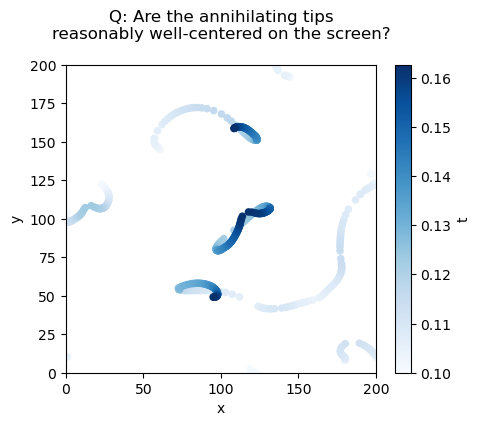

In [16]:
#select the positions of the annihilating tips before the selected annihilation
# t0 = np.around(tf - 0.01,3) #10 ms before
# t0 = np.around(tf - 0.11,3) #10 ms before
# t0 = np.around(tf - 0.02,3) #20 ms before
t0 = np.around(tf - 0.12,3) #20 ms before
boo = (df['t']>=t0)&(df['t']<=tf)
#plot ^those positions
fig,ax=plt.subplots(figsize=(5,4))
df[boo].plot.scatter(x='x',y='y',c='t',cmap='Blues',ax=ax)
ax.set_xlim([0,width])
ax.set_ylim([0,height])
ax.set_title('Q: Are the annihilating tips\nreasonably well-centered on the screen?\n')
plt.show()

In [26]:
t0=0.043
t0=0.1
t0=0.09

In [27]:
# compute number of iterations (half the number of time steps)
iterations = int(np.around(1e3*t0/DT/2))
iterations

1800

In [28]:
#init methods for instantaneous spiral tip detection
diffCoef=kwargs['diffCoef']
dsdpixel=kwargs['DX']
get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
# one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
# V_threshold=-60
V_threshold=0.4
compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

param_fn is param_set_8.json.


In [30]:
assert get_time_step_fk
assert compute_all_spiral_tips

In [31]:
printing=True
# load an initial conditions and integrate forward 100ms
ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/'
ic_fn = os.path.basename(pkl_dir).replace('.pkl','.npz')
ic_dir=os.path.join(ic_folder,ic_fn)
if printing:
    print(f"loaded ic: '{ic_dir}'")

#load ic and verify that it contains spiral tips
txt=load_buffer(ic_dir).astype(np.float64)
t=0
# plt.imshow(txt[...,0],cmap='gray')
# plt.axis('off')
# plt.show()

# time evolve to t0
if printing:
    print(f"forward integrating to t0={t0:.3f} ms (iterations={iterations})...")
#define the initial conditions
u_initial=txt[...,0].copy()
v_initial=txt[...,1].copy()
w_initial=txt[...,2].copy()
#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)
#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)
# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")
# #create events for measuring performance
# start_timer = drv.Event()
# end_timer = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)
#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
# start_timer.record()
start=time.time()
for step in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
#     #update progressbar
#     if printing:
#         printProgressBar(step + 1, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
# end_timer.record()
context.synchronize()
# runtime = end_timer.time_since(start_timer)
print(f"{iterations*2} time steps took {time.time()-start:.3f} seconds.")
#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)
#record final time as new time
# t=t0
# t_init=np.around(t0+0.1,3)
t_init=np.around(t0,3)
t=t_init
#stack txt
txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
#cache txt for initialization
txt_init=txt.copy()
zero_txt=np.zeros_like(txt)
# plt.imshow(txt_init[...,0],cmap='gray')
# plt.axis('off')
# plt.show()
print(f"{t=} s")

loaded ic: '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.3.35.npz'
forward integrating to t0=0.090 ms (iterations=1800)...
3600 time steps took 0.398 seconds.
t=0.09 s


In [38]:
V_threshold=0.4
# V_threshold=0.7
print(f"{V_threshold=}")

V_threshold=0.4


In [41]:
#compute spiral tip locations and verify that they look reasonable
#compute flow map
dtxt_dt=zero_txt.copy()
get_time_step_fk(txt, dtxt_dt)
img=txt[...,0]
dimgdt=dtxt_dt[...,0]
#compute spiral tip locations
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
print_dict(dict_out)

t=0.09
n=4
x=[96.5410256964298, 103.72159966657635, 121.01485475266148, 131.73730149658311]
y=[53.99831166418976, 82.24327877540551, 154.87430222396782, 106.80194295050319]
grad_ux=[1.0608797889279846, -14.451562850308642, 0.9276300303128744, 1.6316579041395254]
grad_uy=[0.891160908790292, 20.492602565712506, 1.0565363578047688, 0.2224686879240404]
grad_vx=[-0.03402196641348828, 0.5631370310013396, 2.5706833172355292, -0.7777866946189795]
grad_vy=[2.851330595490734, 1.5453756088959747, -0.22846727452509494, 3.195909986158248]


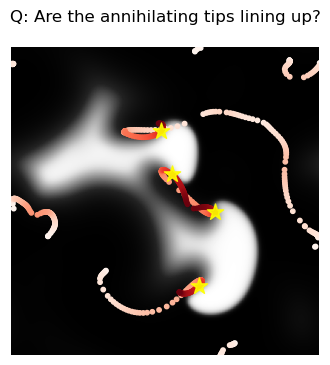

In [42]:
fig,ax=plt.subplots(figsize=(5,4))

#plot tip trajectory
# boon = (df['t']>=t0)&(df['t']<=tf)
boon = (df['t']>=t_init)&(df['t']<=tf)
cbar = df[boon].plot.scatter(x='x',y='y',c='t',cmap='Reds',ax=ax,s=10,colorbar=False)

#plot tip positions
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
if x_values.shape[0]>0:
    boo=(x_values<width-1.)&(y_values<height-1.)
    x_values=x_values[boo]
    y_values=y_values[boo]
    ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)
    
ax.imshow(img,cmap='gray')
# ax.imshow(img[::-1,:],cmap='gray')
#format_plot
ax.axis('off')
# ax.set_xlim([0,width])
# ax.set_ylim([0,height])
ax.set_title('Q: Are the annihilating tips lining up?\n')
plt.show()

In [43]:
# determine save times at t'=4,2,0 ms before the selected annihilation at time tf
DT_save = 0.002 #s
# tsave_lst=sorted([tf,np.around(tf-DT_save,3),np.around(tf-2*DT_save,3)])
t=t_init
tsave_lst=sorted([np.around(t+DT_save,3),np.around(t+2*DT_save,3),np.around(t+3*DT_save,3)])
print(f"integrating ic from {t=} and saving txt at times: {tsave_lst}...")

integrating ic from t=0.09 and saving txt at times: [0.092, 0.094, 0.096]...


In [44]:
#initialize systems
txt=txt_init.copy()
u_initial=txt[...,0].copy()
v_initial=txt[...,1].copy()
w_initial=txt[...,2].copy()
#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)
#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)



# #time evolve txt on gpu
# dict_out_lst=[dict_out]
# img_lst=[img.copy()]
# dimg_dt_lst=[dimgdt.copy()]

#time evolve txt on gpu
txt_lst=[txt.copy()]

t_lst=[t_init]

In [51]:
#compute flow map
dtxt_dt=zero_txt.copy()
get_time_step_fk(txt, dtxt_dt)
img=txt[...,0]
dimgdt=dtxt_dt[...,0]
#compute spiral tip locations
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
print_dict(dict_out)
ninitial = dict_out['n']
print(f"{ninitial=}")
n = ninitial

t=0.09
n=4
x=[96.5410256964298, 103.72159966657635, 121.01485475266148, 131.73730149658311]
y=[53.99831166418976, 82.24327877540551, 154.87430222396782, 106.80194295050319]
grad_ux=[1.0608797889279846, -14.451562850308642, 0.9276300303128744, 1.6316579041395254]
grad_uy=[0.891160908790292, 20.492602565712506, 1.0565363578047688, 0.2224686879240404]
grad_vx=[-0.03402196641348828, 0.5631370310013396, 2.5706833172355292, -0.7777866946189795]
grad_vy=[2.851330595490734, 1.5453756088959747, -0.22846727452509494, 3.195909986158248]
ninitial=4


In [52]:
# for tfinal in tsave_lst:
#     duration=tfinal-t
duration = 0.002 #s
# compute number of iterations (half the number of time steps)
iterations = int(np.around(1e3*(duration)/DT/2))
iterations

40

In [54]:
#integrate until the annihilation has occured
while n>=ninitial:
    #call the GPU kernel 2*iterations times and measure performance
    context.synchronize()
    #start.record()
    for i in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
    #end.record()
    context.synchronize()
    #runtime = end.time_since(start)
    #print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python for plotting
    gpu_result_u = np.zeros_like(u_initial)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_initial)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_initial)
    drv.memcpy_dtoh(gpu_result_w, w_old)
    #stack txt
    t=t+duration
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    #record
    t_lst.append(t)
    txt_lst.append(txt.copy())

    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    # print_dict(dict_out)
    n = dict_out['n']

In [53]:
# TODO: load the corresponding initial conditions and zip to ^those 3 time points. record a snapshot of txt at each time point.
# TODO: plot ^those 3 snapshots as a simple 3 panel figure with a simple grayscale

0.09

In [56]:
num_snapshots=len(t_lst)
print(f"annihilation observed: {t=:.3f}, {num_snapshots=}")

annihilation observed: t=0.12800000000000003, num_snapshots=20


In [68]:
#define coordinate meshes
X_=np.arange(width)
Y_=np.arange(height)

t': tf-t=0.032, num tips: 4
t': tf-t=0.016, num tips: 4
t': tf-t=0.000, num tips: 2


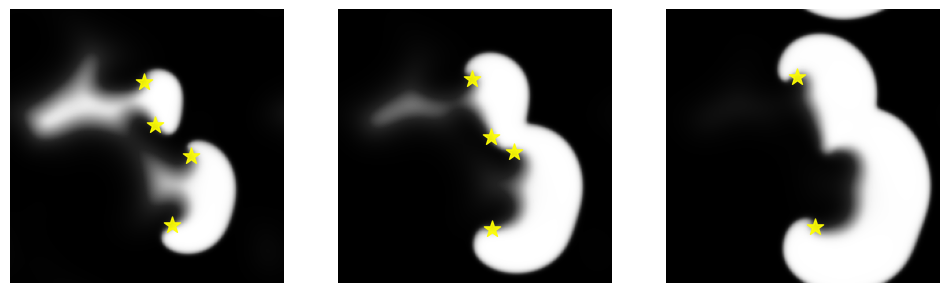

In [69]:
#visualize the tip positions + texture for 3 chosen panels
# index_lst=[-3,-2,-1]
# index_lst=[-1-4,-1-2,-1]
# index_lst=[-1-8,-1-4,-1]
index_lst=[-1-16,-1-8,-1]
tf=t_lst[-1]

fig,axs=plt.subplots(ncols=3,figsize=(12,4))
for ax,index in zip(axs,index_lst):
    txt = txt_lst[index].copy()
    t = t_lst[index].copy()
    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    #print_dict(dict_out)
    print(f"t': {tf-t=:.3f}, num tips: {dict_out['n']}")
    #plot the grayscale image
    ax.imshow(img,cmap='gray')
    #plot tip positions
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)
    #format_plot
    ax.axis('off')
    ax.set_aspect('equal', adjustable='box')

plt.show()    

In [176]:
V_threshold=0.4
# V_threshold=0.45
# V_threshold=0.35

In [179]:
# miny_streamstart = width/3
# maxy_streamstart = 2*width/3
miny_streamstart = 100
maxy_streamstart = 200
# miny_streamstart = 75
# maxy_streamstart = 150

t': tf-t=0.032, num tips: 4
[(118.26511345506621, 157.14569678457613), (131.7282606104297, 106.68574436390135)]
t': tf-t=0.016, num tips: 4
[(111.88564247810085, 159.67119284885112), (128.2527905662343, 104.05256296312828)]
t': tf-t=0.000, num tips: 2
[(108.44149822317438, 158.55890767996945)]


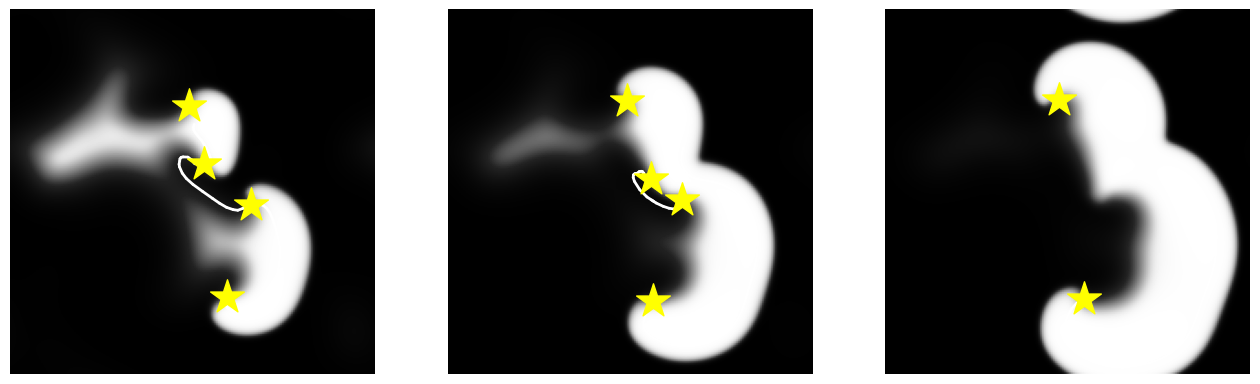

In [251]:
#visualize the tip positions + texture for 3 chosen panels
# index_lst=[-3,-2,-1]
# index_lst=[-1-4,-1-2,-1]
# index_lst=[-1-8,-1-4,-1]
index_lst=[-1-16,-1-8,-1]
tf=t_lst[-1]

fig,axs=plt.subplots(ncols=3,figsize=(16,6))
for ax,index in zip(axs,index_lst):
    txt = txt_lst[index].copy()
    t = t_lst[index].copy()
    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    #print_dict(dict_out)
    print(f"t': {tf-t=:.3f}, num tips: {dict_out['n']}")
    #plot the grayscale image
    ax.imshow(img,cmap='gray')
    #plot tip positions
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
    ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=650,#s=300,
               zorder=10,alpha=1)#,alpha=0.9)
    #format_plot
    ax.axis('off')
    ax.set_aspect('equal', adjustable='box')
    
    #compute vector field
    ddVdtdx=np.gradient(dimgdt,axis=0)/DX #not stable in time
    ddVdtdy=-np.gradient(dimgdt,axis=1)/DX #not stable in time
    vx=ddVdtdx
    vy=ddVdtdy
    #plot streams
    booy = (miny_streamstart<y_values)&(maxy_streamstart>y_values)
    if booy.any():
#         start_points = list(zip(x_values[booy]-0.1,y_values[booy]+0.1))
        start_points = list(zip(x_values[booy],y_values[booy]))
    #     start_points = list(zip(x_values,y_values))
        strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                                  color="white",#"crimson", #"white",#"orange", 
                                  linewidth=2,
                                  arrowsize=1,
                                  arrowstyle='-',#''fancy',#'wedge',#'->',#'-|>',
                                  minlength=0.1,
                                  maxlength=1.0,
                                  integration_direction='forward')#'backward')#'both')
        strmS.lines.set_capstyle('round')
        #extract the stream traces
        stream_array=strmS.lines.properties()['segments']
    print(start_points)
plt.show()    

# generate Fig. 1A

In [230]:
V_threshold=0.4
# V_threshold=0.6

t': tf-t=0.030, num tips: 4
[(131, 106)]


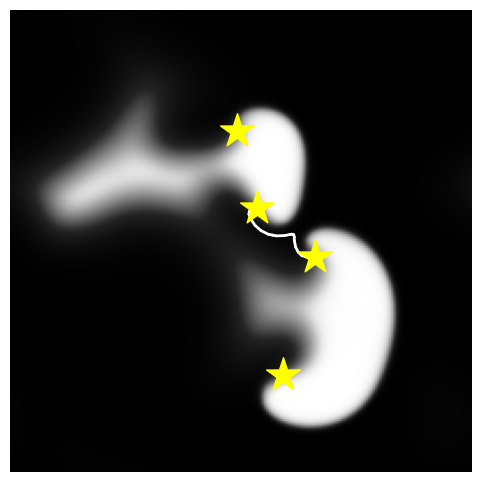

In [245]:
#visualize the tip positions + texture for 3 chosen panels
index_lst=[-1-16,-1-8,-1]
tf=t_lst[-1]
index = index_lst[0]
index=-1-15
# index=-1-16
fig,ax=plt.subplots(ncols=1,figsize=(6,6))
# for ax,index in zip(axs,index_lst):
txt = txt_lst[index].copy()
t = t_lst[index].copy()
#compute flow map
dtxt_dt=zero_txt.copy()
get_time_step_fk(txt, dtxt_dt)
img=txt[...,0]
dimgdt=dtxt_dt[...,0]
#compute spiral tip locations
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
#print_dict(dict_out)
print(f"t': {tf-t=:.3f}, num tips: {dict_out['n']}")
#plot the grayscale image
ax.imshow(img,cmap='gray')
#plot tip positions
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
if x_values.shape[0]>0:
    boo=(x_values<width-1.)&(y_values<height-1.)
    x_values=x_values[boo]
    y_values=y_values[boo]
    ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=650,#s=300,
               zorder=10,alpha=1)#,alpha=0.9)
#format_plot
ax.axis('off')
ax.set_aspect('equal', adjustable='box')

#compute vector field
ddVdtdx=np.gradient(dimgdt,axis=0)/DX #not stable in time
ddVdtdy=-np.gradient(dimgdt,axis=1)/DX #not stable in time
vx=ddVdtdx
vy=ddVdtdy
# #plot streams
# booy = (miny_streamstart<y_values)&(maxy_streamstart>y_values)
# if booy.any():
# #         start_points = list(zip(x_values[booy]-0.1,y_values[booy]+0.1))
#     start_points = list(zip(x_values[booy],y_values[booy]))
# #     start_points = list(zip(x_values,y_values))
# start_points = [(117.49682316610152, 157.71604353774083), (131.67863137903743, 106.5358105810791)]
# start_points = [(117, 157), (131, 106)]
# start_points = [(131, 106)]
start_points = [(131, 106)]
# start_points = [(117, 157)]

strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                          color="white",#"crimson", #"white",#"orange", 
                          linewidth=2,#3,
                          arrowsize=1,
                          arrowstyle='-',#'simple',#''fancy',#'wedge',#'->',#'-|>',
                          minlength=0.1,
                          maxlength=0.25,#1.0,
                          density=1.,
                          integration_direction='forward')#'backward')#'both')
strmS.lines.set_capstyle('round')
# strmS.set(connectionstyle='round')
# strmS.set_connectionstyle("Arc,armA=30,rad=10")
# set_connectionstyle("arc", armA=30, rad=10)
#extract the stream traces
# stream_array=strmS.lines.properties()['segments']
print(start_points)
plt.show()    

In [74]:
#DONE GOAL: get 3 frames showing spiral tips attracting and annihilating
# DONE: concatenate spiral tip number time series
# DONE: concatenate spiral tip positions as df
# DONE: identify time points where n --> n-2 after tstart=0.13 seconds
# DONE: select first of those events after tstart=0.13 seconds
# DONE: select the positions of the annihilating tips at t'=4,2,0 ms before the selected annihilation
# DONE: plot ^those positions
# DONE: sanity check the positions look reasonable enough
# NOTE: i can get away with ignoring particle tracking until i need to annotate.

# DONE: at t'=4,2,0 ms before the selected annihilation at time tf
# DONE: load the corresponding initial conditions and zip to ^those 3 time points. record a snapshot of txt at each time point.
# DONE: plot ^those 3 snapshots as a simple 3 panel figure with a simple grayscale
# DONE: determine spiral tip positions in each panel. overlay them on ^those 3 panels
# DONE: sanity check the panels look reasonable enough. otherwise pick another event.
#  - Q: do positions look right? (convincing V_threshold?)
#  - Q: do annihilating particles jump a periodic boundary? (reasonably centered?)

# DONE: identify which pair annihilated
# DONE: dev overlay to illustrate attractive spiral tip dynamics
#  - Option 1: contour plot of rate of change of voltage field (proxy for polarized/depolarized indicator)
#  - Option 2: contour plot of voltage field
#  - Option 3: annotate future tip motion with streamplot (maybe -grad(dVdt) matches the apparent trajectories reasonably well for the annihilating tips)
#  - Option 4: annotate gradient decent of voltage using streamplot (-grad(V) from the selected tips)

# DONE: make a convincing 3 panel figure for SM / port to .odg
#  - Q: do the markers all look how I want them? (yellow/black stars?)
# DONE: port make ^this generation to make it easy to repeat/modify 

In [ ]:
# #####################################
# # HINT: simulator
# #####################################
# #compute spiral tip locations and verify that they look reasonable
# #compute flow map
# dtxt_dt=zero_txt.copy()
# get_time_step_fk(txt, dtxt_dt)
# img=txt[...,0]
# dimgdt=dtxt_dt[...,0]
# #compute spiral tip locations
# dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
# print_dict(dict_out)
# if dict_out['n']>0:
#     #generation of results
#     # printing=True
#     save_every=67
#     save_every=22 #~30X slowdown
#     fps=60 #i checked the ffmpeg routine
#     # video_duration=30 #seconds
#     video_duration=15 #seconds
#     pause_after_termination_duration=1. #second
#     accumulated_time_after_termination=0.
#     V_threshold=0.4 #appears best
#     # V_threshold=0.2
#     # V_threshold=0.8
#     # V_threshold=0.95
#     #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time

#     #define the initial conditions
#     t=tf #ms
#     txt=txt_init.copy()
#     u_initial=txt[...,0].copy()
#     v_initial=txt[...,1].copy()
#     w_initial=txt[...,2].copy()
#     #don't allocate memory many times for the same task!
#     #allocate GPU memory for voltage scalar field
#     u_old = drv.mem_alloc(u_initial.nbytes)
#     u_new = drv.mem_alloc(u_initial.nbytes)
#     #allocate GPU memory for v and w auxiliary fields
#     v_old = drv.mem_alloc(v_initial.nbytes)
#     v_new = drv.mem_alloc(v_initial.nbytes)
#     w_old = drv.mem_alloc(w_initial.nbytes)
#     w_new = drv.mem_alloc(w_initial.nbytes)

#     # explicit time integration up to 5 seconds in steps of size 0.025 ms
#     kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

#     #setup thread block dimensions and compile the kernel
#     mod = SourceModule(block_size_string+kernel_string)
#     time_step_kernel = mod.get_function("time_step_kernel")

#     # #create events for measuring gpu performance
#     # start_timer = drv.Event()
#     # end_timer = drv.Event()

    

In [ ]:
# #TODO(later): compute streams
# start_points = list(zip(x_values,y_values))
# strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
#                       color="crimson", #"orange", 
#                       linewidth=2,
#                       integration_direction='forward')
# #                       integration_direction='backward')
# #                           integration_direction='both')
# #record the stream for later analysis
# stream_array=strmS.lines.properties()['segments']
# dict_out['stream_array']=stream_array

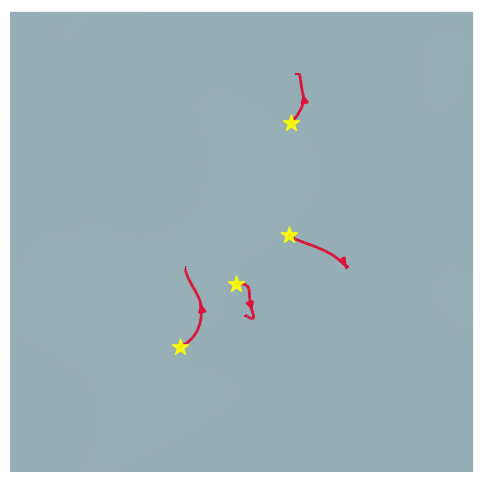

In [189]:
#####################################
# HINT: plotter
#####################################
# #DONE: dev viewer routine_to_png
# #input: dict_out,img,dimg_dt,save_dir
# #output: save_dir
# def routine_to_png_streaming_tips(task):
#     dict_out,img,dimg_dt,save_dir=task
#define constant parameters
# fontsize=22
# xy=(0.75, 0.9)
inch=6
fontsize=30
xy=(0.67, 0.9)
#define constant coordinate mesh for stream generation
width=200.#pixel
height=200.#pixel
DX=0.025#cm/pixel
#generate plot
#fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
ax=fig.add_subplot()
#plot the mesh
X_=np.arange(width)
Y_=np.arange(height)
X,Y = np.meshgrid(X_, Y_)
ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')
# ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')

#compute vector field
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
#     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
#     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
vx=ddVdtdx #still looks meh?
vy=ddVdtdy

#compute the streamplot
# strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
#                      density=0.2)#density=0.5)#jumpy#density=2)#way too much 
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
if x_values.shape[0]>0:
    boo=(x_values<width-1.)&(y_values<height-1.)
    x_values=x_values[boo]
    y_values=y_values[boo]
    start_points = list(zip(x_values,y_values))
    strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                          color="crimson", #"orange", 
                          linewidth=2,
                          integration_direction='forward')
    #                       integration_direction='backward')
#                           integration_direction='both')
    ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

    #record the stream for later analysis
    stream_array=strmS.lines.properties()['segments']
    dict_out['stream_array']=stream_array

# # formatting
# label=r"$-\nabla \partial_tV$"#+'\n'
# ax.annotate(label, xy=xy, 
#             xycoords='axes fraction',
#             fontsize=fontsize,alpha=0.8)

ax.axis("off")
ax.axis([0,width,0,height])
# plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#     plt.close();
#     return save_dir
plt.show()

In [193]:
# #compute flow map
# dtxt_dt=zero_txt.copy()
# get_time_step_fk(txt, dtxt_dt)
# plt.imshow(dtxt_dt[...,0],cmap='bone',vmin=0,vmax=.1)
# plt.axis('off')
# plt.show()

In [66]:
# ##########################
# # visualize the aux fields
# ##########################
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
# ax1.imshow(u_initial)
# ax1.set_title("Initial Conditions\n$u_0$")
# ax2.imshow(gpu_result_u)
# ax2.set_title("Final Result From GPU\n$u$")
# ax3.imshow(v_initial)
# ax3.set_title("$v_0$")
# ax4.imshow(gpu_result_v)
# ax4.set_title("$v$")
# ax5.imshow(w_initial)
# ax5.set_title("$w_0$")
# ax6.imshow(gpu_result_w)
# ax6.set_title("$w$")
# plt.show()

In [ ]:
# #####################################
# # HINT: plotter
# #####################################
# # #DONE: dev viewer routine_to_png
# # #input: dict_out,img,dimg_dt,save_dir
# # #output: save_dir
# # def routine_to_png_streaming_tips(task):
# #     dict_out,img,dimg_dt,save_dir=task
# #define constant parameters
# # fontsize=22
# # xy=(0.75, 0.9)
# inch=6
# fontsize=30
# xy=(0.67, 0.9)
# #define constant coordinate mesh for stream generation
# width=200.#pixel
# height=200.#pixel
# DX=0.025#cm/pixel
# #generate plot
# #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
# fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
# ax=fig.add_subplot()
# #plot the mesh
# X_=np.arange(width)
# Y_=np.arange(height)
# X,Y = np.meshgrid(X_, Y_)
# ax.pcolormesh(X, Y, img,vmin=-80,vmax=40,cmap='bone', shading='gouraud')

# #compute vector field
# #     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
# #     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
# #     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
# #     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
# #     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
# #     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
# ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
# ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
# #     vx=-ddVdtdx #looks good, opposite direction?
# #     vy=-ddVdtdy
# vx=ddVdtdx #still looks meh?
# vy=ddVdtdy

# #compute the streamplot
# # strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
# #                      density=0.2)#density=0.5)#jumpy#density=2)#way too much 
# x_values=np.array(dict_out['x'])
# y_values=np.array(dict_out['y'])
# if x_values.shape[0]>0:
#     boo=(x_values<width-1.)&(y_values<height-1.)
#     x_values=x_values[boo]
#     y_values=y_values[boo]
#     start_points = list(zip(x_values,y_values))
#     strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
#                           color="crimson", #"orange", 
#                           linewidth=2,
#                           integration_direction='forward')
#     #                       integration_direction='backward')
# #                           integration_direction='both')
#     ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

#     #record the stream for later analysis
#     stream_array=strmS.lines.properties()['segments']
#     dict_out['stream_array']=stream_array

# # # formatting
# # label=r"$-\nabla \partial_tV$"#+'\n'
# # ax.annotate(label, xy=xy, 
# #             xycoords='axes fraction',
# #             fontsize=fontsize,alpha=0.8)

# ax.axis("off")
# ax.axis([0,width,0,height])
# # plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
# #     plt.close();
# #     return save_dir
# plt.show()